In [2]:
pip install finance-datareader

Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import time
import pandas as pd
import json
import requests
import FinanceDataReader as fdr
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

In [ ]:
conda install -n base ipykernel --update-deps --force-reinstall

In [4]:
#특정 날짜 23년 2월 2일 크롤링
url = 'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list23&wr_id=2190#section1'
response = requests.get(
    url,
    headers={
        'User-Agent': 'Mozilla 5.0'
    }
    )
bs = BeautifulSoup(response.text, 'lxml')    

In [167]:
#특정 날짜 23년 2월 2일 크롤링
df = pd.DataFrame(columns=['comment'])
for i in range(len(bs.select('.cmt_contents'))):
    comment = bs.select('.cmt_contents')[i].text
    df.loc[i] = [comment]

In [4]:
#게시판에서 각 게시물 주소얻기 
url = 'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list23'
response = requests.get(
    url,
    headers={
        'User-Agent': 'Mozilla 5.0'
    }
    )
bs = BeautifulSoup(response.text, 'lxml') 

In [200]:
#1페이지 링크 얻기
for i in range(len(bs.select('table>tr'))):
    date = bs.select('table>tr')[i].select('dd')[1].text
    url_link = bs.select('table>tr')[i].select('a')[0].get('href')

In [5]:
#해당 년도 모든 페이지에 날짜 url 얻기
#마지막 페이지 찾는 작업 필요 
for page_num in range(1,4):
    url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list22&page={page_num}'
    response = requests.get(
        url,
        headers={
        'User-Agent': 'Mozilla 5.0'
        }
        )
    bs = BeautifulSoup(response.text, 'lxml') 

    for i in range(len(bs.select('table>tr'))):
        date = bs.select('table>tr')[i].select('dd')[1].text
        url_link = bs.select('table>tr')[i].select('a')[0].get('href')

In [8]:
#함수화
def get_info_from_url(url):
    response = requests.get(
        url,
        headers={
        'User-Agent': 'Mozilla 5.0'
        }
    )
    bs = BeautifulSoup(response.text, 'lxml') 
    return bs

In [9]:
#모든 년도 모든 페이지에 날짜 url 얻기
#마지막 페이지 찾는 작업 필요 
df = pd.DataFrame()
for year in tqdm(range(19,24)):
    for page_num in tqdm(range(1,4)):
        url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{year}&page={page_num}'
        bs = get_info_from_url(url)  
        info_from_bs = bs.select('table>tr')
        for bs in info_from_bs:
            try :
                date = bs.select('dd')[1].text
                url_link = bs.select('a')[0].get('href')
                bs = get_info_from_url(url_link)
                data_from_url = bs.select('.cmt_contents')

                for comments in data_from_url:
                    comment = comments.text

                    temp = pd.DataFrame({
                        'date': date,
                        'url': url_link,
                        'comment': comment
                        }, index=[0])

                    df = pd.concat([df, temp], axis=0)
            except IndexError:
                print(1)

100%|██████████| 5/5 [02:36<00:00, 31.31s/it]

1
1


In [41]:
#파일로 저장
df.to_csv('data.csv', index=False, encoding='utf-8-sig')


In [59]:
#파일 불러오기
df = pd.read_csv('./data.csv')

In [60]:
#금일 추천주 필터링
df = df[df['comment'].str.contains('매수', na =False)]
df = df[df['comment'].str.contains('현재시간', na =False)]
df = df[df['comment'].str.contains('▶', na =False)]
df['comment'] = df.comment.apply(lambda x : re.sub('\\n','',x))

In [61]:
#date 를 datetime 형식으로 변환 1
df['date'] = df.date.apply(lambda x : x.replace(".",""))
df['date']= df['date'].astype('str')
df['date'] = df.date.apply(lambda x : datetime.strptime(x,'%Y%m%d'))
df = df.reset_index(drop=True)

In [63]:
#date 를 datetime 형식으로 변환 2
#df2 = df 
#df2['date'] = pd.to_datetime(df2['date'])

In [64]:
# # 예외찾기
# df2 = df['slicing_comment'].apply(lambda x : x == [] )
# df2[df2]

In [65]:
#예외처리
df.comment[54] = df.comment[54].replace('\xa0',' ')

C:\Users\admin\AppData\Local\Temp\ipykernel_16464\3069763651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.comment[54] = df.comment[54].replace('\xa0',' ')


In [66]:
#종목 슬라이스
df['slicing_comment'] = df.comment.apply(lambda x : re.findall('\d+분 ([가-힣A-z]+)',x)[0])

In [67]:
#종목명 추출
recommended_stock = df.filter(items=['date','slicing_comment'])
recommended_stock = recommended_stock.rename(columns={'slicing_comment':'stock_name'})

In [68]:
#데이터프레임 한번에 보기
#pd.set_option('display.max_rows', None)
#다시 돌리기
#pd.options.display.max_rows = 100

In [69]:
#대소변환
recommended_stock['stock_name'] = recommended_stock.stock_name.str.upper()

In [70]:
#주가 기본정보 불러오기
Kospi_df = pd.read_csv('./kospi_code.csv')
Kosdaq_df = pd.read_csv('./kosdaq_code.csv')
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])

In [71]:
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])

In [72]:
#종목 코드 합치기 1트
stock = pd.merge(recommended_stock, kospi_kosdaq, how = 'left', on  = 'stock_name')

In [73]:
#누락된NaN 버리기
stock1 = stock.dropna()

In [74]:
#누락된NaN 값들중 주울거 있는지 확인하기 
stock2 = stock.drop(stock1.index,axis=0)
stock2 = stock2.drop(['stock_code'],axis=1)

In [75]:
#누락된 종목코드 찾기
# exception = stock[stock.stock_code.isnull()]
exception = stock.drop(stock1.index,axis=0)

In [36]:
#파일로 저장
#exception.to_csv('exception.csv', index=False, encoding='utf-8-sig')

In [76]:
#파일불러오기
exception = pd.read_csv('./exception.csv')

In [77]:
#exception 정제
exception = exception.dropna()
exception['stock_code'] = exception.stock_code.apply(lambda x : str(int(x)).zfill(6))
exception = exception.filter(items = ['stock_name','stock_code'])

In [78]:
#종목 코드 합치기 2트
stock2 = pd.merge(stock2, exception, how = 'left', on  = 'stock_name')
stock2 = stock2.dropna()

In [79]:
#최종 stock 가져오기 stock = stock1+stock2
stock = pd.concat([stock1,stock2])
stock = stock.sort_values(by=['date'], ascending=[True])
stock = stock.reset_index(drop= True)

In [5]:
#파일로 저장
# stock.to_csv('recommend_stock.csv', index=False, encoding='utf-8-sig')
#파일 불러오기
stock = pd.read_csv('./recommend_stock.csv')

In [20]:
stock['date'] = stock.date.apply(lambda x : re.sub("-","",x))
stock['date']= stock['date'].astype('str')
stock['date'] = stock.date.apply(lambda x : datetime.strptime(x,'%Y.%m.%d'))


In [34]:
stock['date'] = stock.date.apply(lambda x : re.sub("-","",x))

In [6]:
stock

,date,stock_name,stock_code
0,2019-10-29,알리코제약,260660
1,2019-10-29,KPX생명과학,114450
2,2019-10-29,제일바이오,052670
3,2019-10-30,아스타,246720
4,2019-10-30,SM,063440
...,...,...,...
977,2023-02-01,오픈베이스,049480
978,2023-02-01,일성건설,013360
979,2023-02-02,선익시스템,171090
980,2023-02-02,누리플렉스,040160


In [8]:
#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [166]:
#당일최고가 가져오기 
def get_info_from_kisapi(stock_code,date):
    time.sleep(0.1)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST03010100"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":stock_code,
        "FID_INPUT_DATE_1" : date,
        "FID_INPUT_DATE_2" : date,
        "FID_PERIOD_DIV_CODE" : "D",
        "FID_ORG_ADJ_PRC" : "1"
    }

    res = requests.get(URL, headers=headers, params=params)
    stck_hgpr = res.json().get('output2')[0].get('stck_hgpr')
    
    return stck_hgpr

In [67]:
#개장일 계산기
def checking_tr_day(date):
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
        "authorization": f"Bearer {ACCESS_TOKEN}",
        "appKey":APP_KEY,
        "appSecret":APP_SECRET,
        "tr_id":"CTCA0903R"
        }

    params = {
    "BASS_DT": date,
    "CTX_AREA_NK":"",
    "CTX_AREA_FK":""
    }

    res = requests.get(URL, headers=headers, params=params)
    opnd_yn = res.json().get('output')[0].get('opnd_yn')
    return opnd_yn


In [42]:
df_krx = fdr.StockListing('KRX')

In [100]:
#종목 일자별 설정
date = pd.date_range(end = stock.date[269],periods=10)
date = date.strftime("%Y.%m.%d")
start_date = date[0]
end_date = date[-1]

#데이터프레임 불러오기
stock_price = fdr.DataReader(stock.stock_code[269], start_date, end_date)

#전일종가
stock_bf = stock_price.iloc[-2:-1,:].filter(items = ['Close'])
stock_bf = stock_bf.rename(columns={'Close':'content'})
stock_bf.index = ['bf_price']

#당일시가
stock_tr = stock_price.iloc[-1:,:].filter(items = ['Open'])
stock_tr = stock_tr.rename(columns={'Open':'content'})
stock_tr.index = ['tr_price']

#평균거래량
stock_bfvol = stock_price.iloc[-6:-1,:].filter(items = ['Volume'])
stock_bfvol = stock_bfvol.rename(columns={'Volume':'content'})
# stock_bfvol.index = ['D-5','D-4','D-3','D-2','D-1']

#당일거래량
stock_trvol = stock_price.iloc[-1:,:].filter(items = ['Volume'])
stock_trvol = stock_trvol.rename(columns={'Volume':'content'})
stock_trvol.index = ['D-day']

#합치기
stock_info = pd.concat([stock_bf,stock_tr,stock_bfvol,stock_trvol])
stock_info = stock_info.transpose()
stock_info.index = [stock.stock_code[269]]
stock_info = stock_info.reset_index()
stock_info = stock_info.rename(columns={'index':'stock_code'})

In [117]:
# 데이터프레임 한번에 보기
# pd.set_option('display.max_rows', None)
# 다시 돌리기
pd.options.display.max_rows = 100

In [115]:
temp = pd.DataFrame()
for i in range(len(stock)):
    
    #종목 일자별 설정
    date = pd.date_range(end = stock.date[i],periods=20)
    date = date.strftime("%Y.%m.%d")
    start_date = date[0]
    end_date = date[-1]

    #데이터프레임 불러오기
    stock_price = fdr.DataReader(stock.stock_code[i], start_date, end_date)

    #전일종가
    stock_bf = stock_price.iloc[-2:-1,:].filter(items = ['Close'])
    stock_bf = stock_bf.rename(columns={'Close':'content'})
    stock_bf.index = ['bf_price']

    #당일시가
    stock_tr = stock_price.iloc[-1:,:].filter(items = ['Open'])
    stock_tr = stock_tr.rename(columns={'Open':'content'})
    stock_tr.index = ['tr_price']

    #평균거래량
    stock_bfvol = stock_price.iloc[-6:-1,:].filter(items = ['Volume'])
    stock_bfvol = stock_bfvol.rename(columns={'Volume':'content'})
    stock_bfvol.index = ['D-5','D-4','D-3','D-2','D-1']

    #당일거래량
    stock_trvol = stock_price.iloc[-1:,:].filter(items = ['Volume'])
    stock_trvol = stock_trvol.rename(columns={'Volume':'content'})
    stock_trvol.index = ['D-day']

    #합치기
    stock_info = pd.concat([stock_bf,stock_tr,stock_bfvol,stock_trvol])
    stock_info = stock_info.transpose()
    stock_info.index = [stock.stock_code[i]]
    stock_info = stock_info.reset_index()
    stock_info = stock_info.rename(columns={'index':'stock_code'})
    
    temp = pd.concat([temp,stock_info])

In [134]:
temp.to_csv('temp.csv', index=False, encoding='utf-8-sig')

In [7]:
temp = pd.read_csv('./temp.csv')

In [8]:
temp = temp.drop(columns ='stock_code')

In [12]:
temp

,bf_price,tr_price,D-5,D-4,D-3,D-2,D-1,D-day
0,7830,8599,508967,1510701,383465,190690,2999561,7971137
1,6880,7380,9614355,1349265,1154676,8135306,5500002,7226351
2,2487,2881,1614311,1881342,974744,942398,3580814,25005590
3,7760,8020,6383,13511,9833,234641,1309661,4124096
4,2365,2670,13797257,27005706,12792109,17221417,14311347,29449419
...,...,...,...,...,...,...,...,...
977,3220,3280,9668849,6418084,2127904,4129695,2392903,6556918
978,2640,2700,196895,200226,978511,852637,1204040,3197820
979,21000,22050,409859,251387,235463,168614,744548,1762833
980,5890,6150,378487,264823,329709,174303,187972,3763972


In [9]:
stock

,date,stock_name,stock_code
0,2019-10-29,알리코제약,260660
1,2019-10-29,KPX생명과학,114450
2,2019-10-29,제일바이오,052670
3,2019-10-30,아스타,246720
4,2019-10-30,SM,063440
...,...,...,...
977,2023-02-01,오픈베이스,049480
978,2023-02-01,일성건설,013360
979,2023-02-02,선익시스템,171090
980,2023-02-02,누리플렉스,040160


In [10]:
stock = pd.concat([stock, temp], axis=1)

In [11]:
stock

,date,stock_name,stock_code,bf_price,tr_price,D-5,D-4,D-3,D-2,D-1,D-day
0,2019-10-29,알리코제약,260660,7830,8599,508967,1510701,383465,190690,2999561,7971137
1,2019-10-29,KPX생명과학,114450,6880,7380,9614355,1349265,1154676,8135306,5500002,7226351
2,2019-10-29,제일바이오,052670,2487,2881,1614311,1881342,974744,942398,3580814,25005590
3,2019-10-30,아스타,246720,7760,8020,6383,13511,9833,234641,1309661,4124096
4,2019-10-30,SM,063440,2365,2670,13797257,27005706,12792109,17221417,14311347,29449419
...,...,...,...,...,...,...,...,...,...,...,...
977,2023-02-01,오픈베이스,049480,3220,3280,9668849,6418084,2127904,4129695,2392903,6556918
978,2023-02-01,일성건설,013360,2640,2700,196895,200226,978511,852637,1204040,3197820
979,2023-02-02,선익시스템,171090,21000,22050,409859,251387,235463,168614,744548,1762833
980,2023-02-02,누리플렉스,040160,5890,6150,378487,264823,329709,174303,187972,3763972


In [134]:
#가격 변화율
stock['pr_changes'] = stock.filter(items= ['bf_price','tr_price']).pct_change(axis=1).drop(columns = 'bf_price')
stock['pr_changes(%)'] = stock.pr_changes.apply(lambda x : round(x*100,2))

#평균거래량(5일) 및 당일 거래량
stock['vol_mean'] = stock.filter(regex = 'D-\d').mean(axis = 1)
stock['vol_tr'] = stock.filter(items= ['D-day'])

#거래량 변화율
stock['vol_changes'] = stock.filter(items= ['vol_mean','D-day']).pct_change(axis=1).dropna(axis = 1)
stock['vol_changes(%)'] = stock.vol_changes.apply(lambda x : round(x*100,2))

#당일 최고가 가져오기
stock['stck_hgpr'] = stock.apply(lambda x : get_info_from_kisapi(x.stock_code , x.date), axis =1)
stock['stck_hgpr'] = stock.stck_hgpr.apply(lambda x : int(x))

#시가~고가 변화율 
stock['tr_changes'] = stock.filter(items= ['tr_price','stck_hgpr']).pct_change(axis = 1).dropna(axis = 1)
stock['tr_changes(%)'] = stock.tr_changes.apply(lambda x : round(x*100,2))

In [243]:
#필요한 데이터 가져오기 
stock_data = stock.filter(['pr_changes','vol_changes','tr_changes'])
#무한값 제거 
inf_index = stock_data.query('vol_changes>100000').index
stock_data = stock_data.drop(index = inf_index)

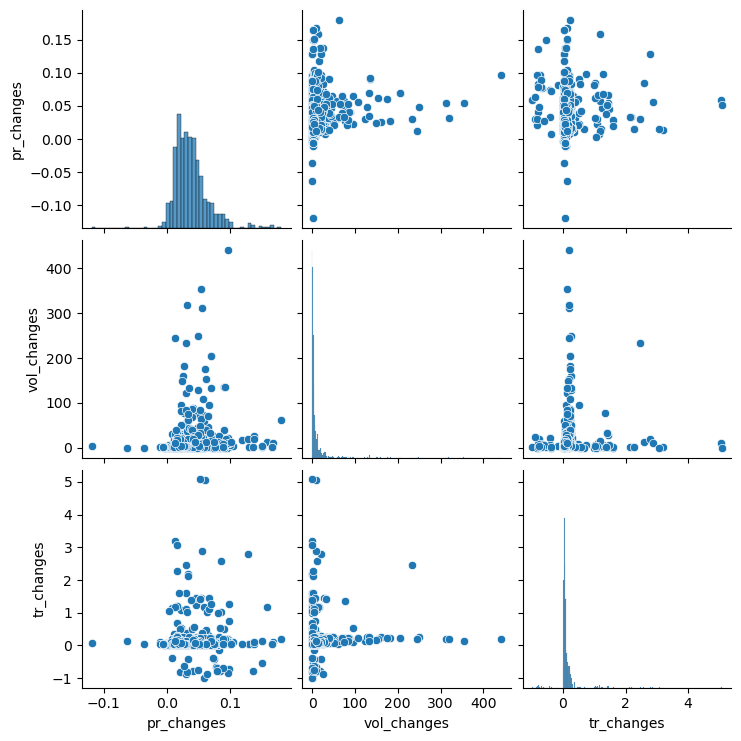

In [235]:
#산전도 그리기
%matplotlib inline
sns.pairplot(stock_data)


In [244]:
#모델링 - > 실패 
model = sm.OLS.from_formula('tr_changes ~ pr_changes+vol_changes', stock_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tr_changes   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.986
Date:                Sat, 18 Feb 2023   Prob (F-statistic):             0.0189
Time:                        12:49:20   Log-Likelihood:                -506.02
No. Observations:                 977   AIC:                             1018.
Df Residuals:                     974   BIC:                             1033.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1088      0.023      4.799      0.000       0.064       0.153
pr_changes      0.4539      0.493      0.920      0.358      -0.514       1.422
vol_changes     0.0010      0.000      2.536      0.011       0.000       0.002
==============================================================================
Omnibus:                     1190.946   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141898.519
Skew:                           6.192   Prob(JB):                         0.00
Kurtosis:                      60.727   Cond. No.                     1.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [189]:
#support Vector machine
#Rogistic Regression 

In [264]:
#Rogistic Regression 방법 시도 
#상승 하락 여부 확인 
stock['price_gap'] = stock.stck_hgpr.apply(lambda x : x) - stock.tr_price.apply(lambda x : x)
stock['dt_price'] = stock.price_gap.apply(lambda x : 1 if x>0 else 0)

In [291]:
stock

,date,stock_name,stock_code,bf_price,tr_price,D-5,D-4,D-3,D-2,D-1,...,pr_changes(%),vol_mean,vol_tr,vol_changes,vol_changes(%),stck_hgpr,tr_changes,tr_changes(%),price_gap,dt_price
0,20191029,알리코제약,260660,7830,8599,508967,1510701,383465,190690,2999561,...,9.82,1118676.8,7971137,6.125505,612.55,15000,0.744389,74.44,6401,1
1,20191029,KPX생명과학,114450,6880,7380,9614355,1349265,1154676,8135306,5500002,...,7.27,5150720.8,7226351,0.402979,40.30,8940,0.211382,21.14,1560,1
2,20191029,제일바이오,052670,2487,2881,1614311,1881342,974744,942398,3580814,...,15.84,1798721.8,25005590,12.901866,1290.19,6260,1.172857,117.29,3379,1
3,20191030,아스타,246720,7760,8020,6383,13511,9833,234641,1309661,...,3.35,314805.8,4124096,12.100445,1210.04,9990,0.245636,24.56,1970,1
4,20191030,SM,063440,2365,2670,13797257,27005706,12792109,17221417,14311347,...,12.90,17025567.2,29449419,0.729717,72.97,2770,0.037453,3.75,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,20230201,오픈베이스,049480,3220,3280,9668849,6418084,2127904,4129695,2392903,...,1.86,4947487.0,6556918,0.325303,32.53,3450,0.051829,5.18,170,1
978,20230201,일성건설,013360,2640,2700,196895,200226,978511,852637,1204040,...,2.27,686461.8,3197820,3.658409,365.84,2880,0.066667,6.67,180,1
979,20230202,선익시스템,171090,21000,22050,409859,251387,235463,168614,744548,...,5.00,361974.2,1762833,3.870052,387.01,22950,0.040816,4.08,900,1
980,20230202,누리플렉스,040160,5890,6150,378487,264823,329709,174303,187972,...,4.41,267058.8,3763972,13.094170,1309.42,6650,0.081301,8.13,500,1


In [293]:
stock_data_re2 = stock.filter(items= ['pr_changes','vol_changes','dt_price'])
inf_index = stock_data_re2.query('vol_changes>100000').index
stock_data_re2 = stock_data_re2.drop(index = inf_index)

In [306]:
Y = stock_data_re2['dt_price']
X = stock_data_re2[['pr_changes','vol_changes']]

In [307]:
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.116391
         Iterations 10


In [308]:
print( results.summary() )

                           Logit Regression Results                           
Dep. Variable:               dt_price   No. Observations:                  977
Model:                          Logit   Df Residuals:                      974
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                  0.1050
Time:                        13:16:29   Log-Likelihood:                -113.71
converged:                       True   LL-Null:                       -127.06
Covariance Type:            nonrobust   LLR p-value:                 1.601e-06
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.5617      0.363     12.568      0.000       3.850       5.273
pr_changes    -26.7937      5.004     -5.354      0.000     -36.602     -16.985
vol_changes     0.0408      0.027      1.517    